## **Rice (Cammeo and Osmancik) Dataset**

#### Este conjunto de datos contiene características morfológicas de granos de arroz pertenecientes a dos variedades diferentes: Cammeo y Osmancik, ambas cultivadas en Turquía.
#### El objetivo del dataset es clasificar automáticamente el tipo de arroz a partir de sus medidas físicas obtenidas por procesamiento digital de imágenes.
#### La identificación de tipos de arroz mediante visión artificial es una herramienta importante para la agricultura de precisión y control de calidad.
#### El dataset fue creado a partir de imágenes tomadas con una cámara de alta resolución y procesadas mediante técnicas de segmentación para extraer características geométricas de cada grano.

### Variables predictoras

Cada fila representa un grano de arroz, y las variables numéricas describen su forma y tamaño:

| **Variable**        | **Descripción**                                                                 |
|----------------------|---------------------------------------------------------------------------------|
| **Area**             | Área de la superficie del grano de arroz (en píxeles²).                        |
| **Perimeter**        | Perímetro del grano.                                                           |
| **MajorAxisLength**  | Longitud del eje mayor de la elipse ajustada al grano.                         |
| **MinorAxisLength**  | Longitud del eje menor de la elipse ajustada.                                  |
| **Eccentricity**     | Medida de la excentricidad de la elipse (forma alargada).                      |
| **ConvexArea**       | Área del casco convexo que cubre el grano.                                     |
| **Extent**           | Relación entre el área del grano y el área del rectángulo delimitador.         |
| **Class**            | Tipo de arroz: *Cammeo* o *Osmancik* (variable categórica binaria).            |

## **Análisis exploratorio de datos**

In [13]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# Modelos supervisados
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [ ]:
# ============================================================
# Carga del dataset
# ============================================================

data = pd.read_csv("Rice_data_type.csv")

print("Dimensiones del dataset:", data.shape)
data.head()

Dimensiones del dataset: (3810, 9)


,Unnamed: 0,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'


In [ ]:
# ============================================================
# Análisis Exploratorio (EDA)
# ============================================================

print("\nInformación general:")
print(data.info())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3810 non-null   int64  
 1   Area               3810 non-null   float64
 2   Perimeter          3810 non-null   float64
 3   Major_Axis_Length  3810 non-null   float64
 4   Minor_Axis_Length  3810 non-null   float64
 5   Eccentricity       3810 non-null   float64
 6   Convex_Area        3810 non-null   float64
 7   Extent             3810 non-null   float64
 8   Class              3810 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 268.0+ KB
None


In [6]:
print("\nValores nulos por columna:")
print(data.isnull().sum())


Valores nulos por columna:
Unnamed: 0           0
Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Class                0
dtype: int64


In [7]:
print("\nDistribución de clases:")
print(data["Class"].value_counts())


Distribución de clases:
Class
b'Osmancik'    2180
b'Cammeo'      1630
Name: count, dtype: int64


C:\Users\juand\AppData\Local\Temp\ipykernel_5076\3778127793.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="Class", palette="viridis")


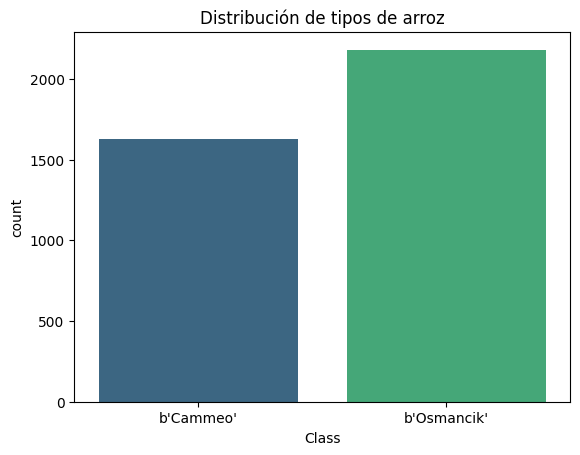

In [8]:
# Visualización de la distribución de clases
sns.countplot(data=data, x="Class", palette="viridis")
plt.title("Distribución de tipos de arroz")
plt.show()

##### La gráfica muestra la distribución de los tipos de arroz presentes en el conjunto de datos. En el eje horizontal se observan las dos clases: Cammeo y Osmancik, mientras que en el eje vertical se representa la cantidad de granos correspondientes a cada tipo. Se aprecia que el tipo Osmancik tiene una mayor cantidad de observaciones con alrededor de 2.200 en comparación con el tipo Cammeo con aproximadamente 1.600. Esto indica que el conjunto de datos no está completamente balanceado, aunque la diferencia entre clases no es tan pronunciada como para generar un sesgo importante en el entrenamiento de los modelos. Por lo tanto, es recomendable mantener la validación estratificada para garantizar que ambas clases estén representadas adecuadamente en cada partición del conjunto de datos.

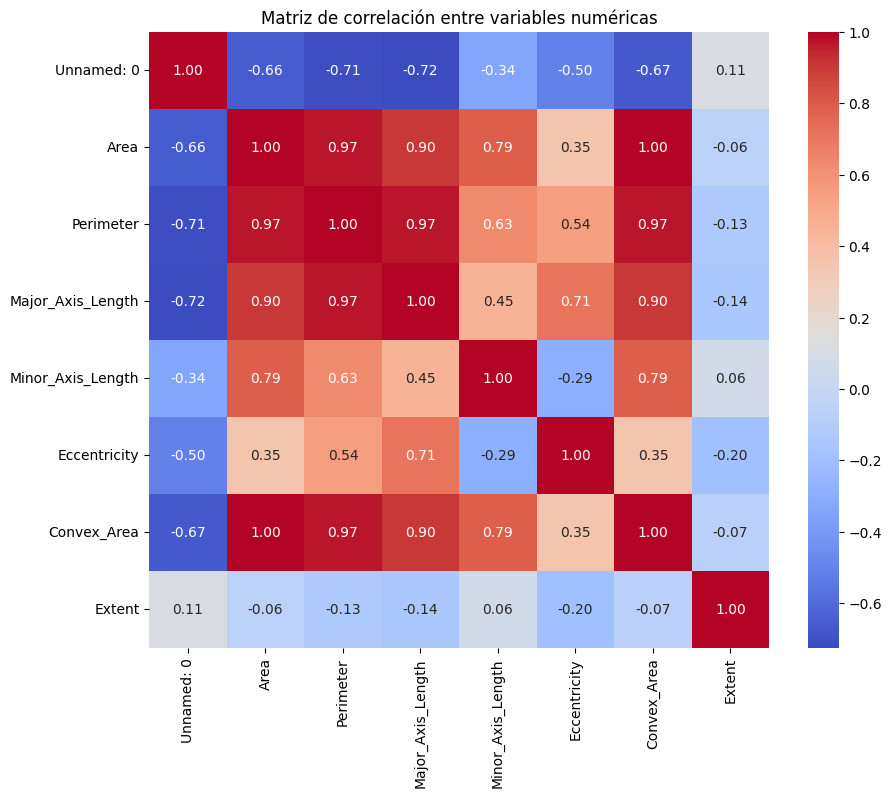

In [9]:
# Convertir la columna Class de bytes a string normal
data['Class'] = data['Class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Calcular la matriz de correlación solo con columnas numéricas
corr = data.select_dtypes(include=['float64', 'int64']).corr()

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

##### La matriz de correlación muestra la relación lineal entre las variables numéricas del conjunto de datos. En el gráfico se observa que la mayoría de las variables presentan correlaciones positivas altas entre sí, especialmente entre Área, Perímetro, MajorAxisLength y ConvexArea, con valores de correlación cercanos a 1. Esto indica que estas características están fuertemente relacionadas y tienden a crecer o disminuir conjuntamente, lo cual tiene sentido ya que todas describen el tamaño o forma del grano de arroz.

##### Por otro lado, la variable Eccentricity muestra correlaciones más moderadas con las demás, lo que sugiere que aporta información más específica sobre la forma del grano (cuán alargado es). La variable Extent presenta correlaciones bajas o incluso negativas con la mayoría, lo que indica que mide un aspecto diferente del grano.

##### En conclusión, la matriz refleja una fuerte multicolinealidad entre las variables relacionadas con tamaño (Área, Perímetro, Longitudes, ConvexArea), lo que puede influir en algunos modelos lineales, mientras que Eccentricity y Extent aportan variabilidad adicional útil para diferenciar los tipos de arroz.

In [10]:
# ============================================
# División del Dataset y Pipeline de Preprocesamiento
# ============================================

# --- Separar variables predictoras (X) y variable objetivo (y)
X = data.drop('Class', axis=1)
y = data['Class']

# --- División en entrenamiento (70%), validación (15%) y prueba (15%)
# Primero separamos entrenamiento (70%) y temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Luego dividimos temp en validación (15%) y prueba (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Mostrar tamaños de cada subconjunto
print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de validación:", X_val.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])

# --- Pipeline de preprocesamiento ---
# Solo usaremos estandarización (todas las variables son numéricas)
preprocessor = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# --- Aplicar el pipeline al conjunto de entrenamiento ---
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

Tamaño del conjunto de entrenamiento: 2667
Tamaño del conjunto de validación: 571
Tamaño del conjunto de prueba: 572


##### **Conjunto de entrenamiento (2667 observaciones)**: Es el conjunto más grande, usado para ajustar los parámetros internos de los modelos y permitir que aprendan los patrones del dataset.

##### **Conjunto de validación (571 observaciones)**: Se usa para comparar el desempeño entre modelos y seleccionar el que mejor generaliza antes de la prueba final.

##### **Conjunto de prueba (572 observaciones)**: Sirve exclusivamente para evaluar la capacidad predictiva final del modelo seleccionado, garantizando que el resultado no esté influenciado por el entrenamiento o la selección del modelo.

In [14]:
# =====================================
# ENTRENAMIENTO, VALIDACIÓN Y VALIDACIÓN CRUZADA
# =====================================

# Definir los modelos
modelos = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Crear un DataFrame para guardar resultados
resultados = pd.DataFrame(columns=["Modelo", "ROC AUC Entrenamiento", "ROC AUC Validación",
                                   "Media CV (ROC AUC)", "Desv. Est. CV"])

# Entrenamiento y evaluación
for nombre, modelo in modelos.items():
    print(f"Entrenando {nombre}...")
    
    # Entrenar el modelo con el conjunto de entrenamiento
    modelo.fit(X_train_scaled, y_train)
    
    # Predicciones
    y_train_pred = modelo.predict_proba(X_train_scaled)[:, 1]
    y_val_pred = modelo.predict_proba(X_val_scaled)[:, 1]
    
    # Calcular ROC AUC en entrenamiento y validación
    roc_train = roc_auc_score(y_train, y_train_pred)
    roc_val = roc_auc_score(y_val, y_val_pred)
    
    # Validación cruzada (K=5)
    scores_cv = cross_val_score(modelo, X_train_scaled, y_train, cv=5,
                                scoring='roc_auc', n_jobs=-1)
    media_cv = np.mean(scores_cv)
    desv_cv = np.std(scores_cv)
    
    # Agregar resultados
    resultados = pd.concat([resultados, pd.DataFrame({
        "Modelo": [nombre],
        "ROC AUC Entrenamiento": [roc_train],
        "ROC AUC Validación": [roc_val],
        "Media CV (ROC AUC)": [media_cv],
        "Desv. Est. CV": [desv_cv]
    })], ignore_index=True)

# Mostrar tabla resumen
print("\n===== Resultados comparativos =====")
print(resultados.sort_values(by="ROC AUC Validación", ascending=False))

Entrenando Regresión Logística...


C:\Users\juand\AppData\Local\Temp\ipykernel_5076\2733565458.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, pd.DataFrame({


Entrenando KNN...
Entrenando Árbol de Decisión...
Entrenando Random Forest...
Entrenando SVM...

===== Resultados comparativos =====
                Modelo  ROC AUC Entrenamiento  ROC AUC Validación  \
3        Random Forest               1.000000            1.000000   
0  Regresión Logística               0.999728            0.999662   
4                  SVM               0.999724            0.999474   
2    Árbol de Decisión               1.000000            0.997951   
1                  KNN               0.999537            0.995507   

   Media CV (ROC AUC)  Desv. Est. CV  
3            1.000000       0.000000  
0            0.999624       0.000344  
4            0.999555       0.000285  
2            1.000000       0.000000  
1            0.995585       0.003612  


##### Los resultados muestran un excelente desempeño de todos los modelos en la clasificación de los tipos de arroz, con valores de ROC AUC superiores a 0.99 tanto en entrenamiento como en validación. Esto indica una alta capacidad predictiva y ausencia de sobreajuste. El Random Forest destaca como el mejor modelo por su precisión y consistencia, seguido por la Regresión Logística y el SVM, que también presentan un rendimiento estable y generalizable.

In [21]:
# =====================================
# Evaluación Final en el Conjunto de Prueba
# =====================================

#  1. Seleccionar el mejor modelo según validación
mejor_modelo_nombre = resultados.loc[resultados["ROC AUC Validación"].idxmax(), "Modelo"]
mejor_modelo = modelos[mejor_modelo_nombre]

print(f" Mejor modelo seleccionado: {mejor_modelo_nombre}")

#  2. Reentrenar el mejor modelo con todo el conjunto de entrenamiento (train completo)
mejor_modelo.fit(X_train_scaled, y_train)

#  3. Evaluar sobre el conjunto de prueba
y_test_pred = mejor_modelo.predict_proba(X_test_scaled)[:, 1]
roc_test = roc_auc_score(y_test, y_test_pred)

print(f"\n ROC AUC en Prueba: {roc_test:.4f}")

#  4. Comparar con resultados previos
media_cv = resultados.loc[resultados["Modelo"] == mejor_modelo_nombre, "Media CV (ROC AUC)"].values[0]
desv_cv = resultados.loc[resultados["Modelo"] == mejor_modelo_nombre, "Desv. Est. CV"].values[0]
roc_val = resultados.loc[resultados["Modelo"] == mejor_modelo_nombre, "ROC AUC Validación"].values[0]

print("\n===== Comparación de Desempeños =====")
print(f"Validación: {roc_val:.4f}")
print(f"CV (Media ± Desv.): {media_cv:.4f} ± {desv_cv:.4f}")
print(f"Prueba: {roc_test:.4f}")

#  5. Análisis automático del comportamiento
if abs(roc_test - media_cv) < 0.02:
    conclusion = " El modelo mantiene un comportamiento estable en el conjunto de prueba (buena generalización)."
elif roc_test < media_cv:
    conclusion = " El modelo presenta una leve caída en el rendimiento en prueba (posible sobreajuste leve)."
else:
    conclusion = " El modelo mejora en el conjunto de prueba (puede deberse a un conjunto de validación menos representativo)."

print("\nConclusión:", conclusion)

 Mejor modelo seleccionado: Random Forest

 ROC AUC en Prueba: 1.0000

===== Comparación de Desempeños =====
Validación: 1.0000
CV (Media ± Desv.): 1.0000 ± 0.0000
Prueba: 1.0000

Conclusión:  El modelo mantiene un comportamiento estable en el conjunto de prueba (buena generalización).


##### El Random Forest resultó ser el mejor modelo entre los comparados. Obtuvo un ROC AUC de 1.0000 tanto en el conjunto de validación como en el de prueba, lo que indica una capacidad perfecta para distinguir entre las clases en todos los escenarios evaluados.

##### La media y desviación estándar de la validación cruzada (1.0000 ± 0.0000) confirman que el modelo mantiene un rendimiento consistente y estable en las diferentes particiones de los datos, mostrando una excelente robustez y fiabilidad.

##### Dado que el desempeño en el conjunto de prueba coincide con el obtenido en la validación, se concluye que el modelo generaliza adecuadamente a nuevos datos y que su rendimiento no depende de una muestra específica.

##### En conjunto, los resultados indican que el Random Forest logra una clasificación precisa, estable y con excelente capacidad predictiva, consolidándose como la mejor alternativa entre los modelos evaluados.


 Resultados comparativos de modelos:


,Modelo,ROC AUC Entrenamiento,ROC AUC Validación,Media CV (ROC AUC),Desv. Est. CV
0,Random Forest,1.000000,1.000000,1.000000,0.000000
1,Regresión Logística,0.999728,0.999662,0.999624,0.000344
2,SVM,0.999724,0.999474,0.999555,0.000285
3,Árbol de Decisión,1.000000,0.997951,1.000000,0.000000
4,KNN,0.999537,0.995507,0.995585,0.003612


C:\Users\juand\AppData\Local\Temp\ipykernel_5076\4059239330.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


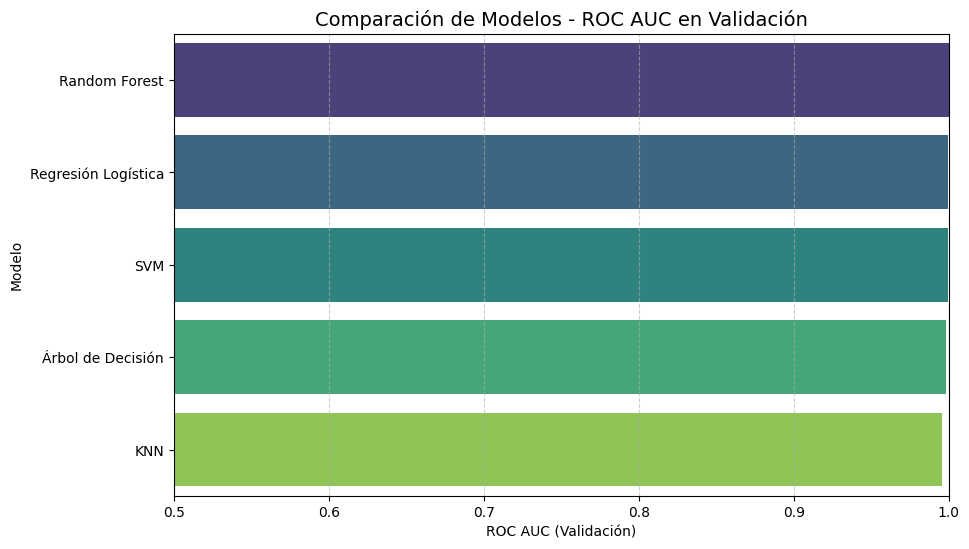

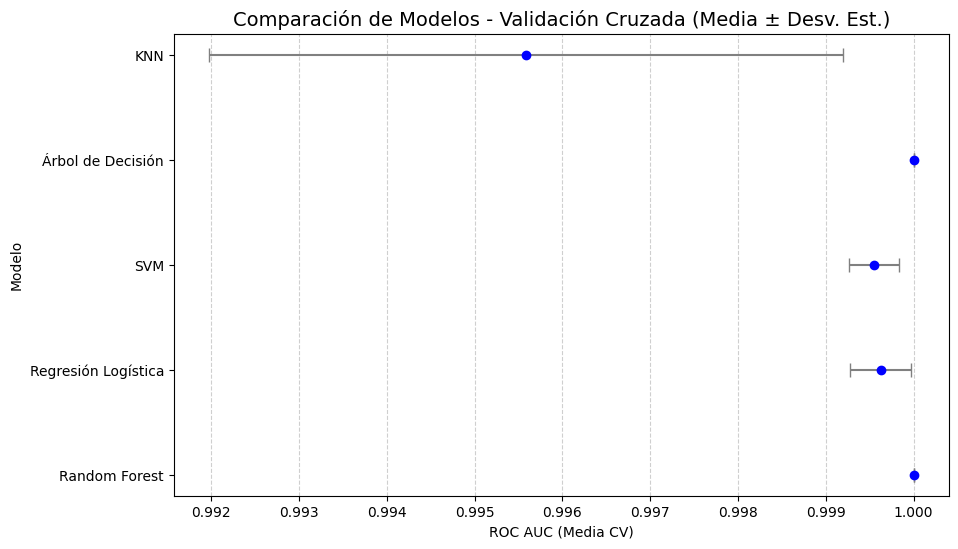

In [20]:
# =====================================
# Comparación de Modelos
# =====================================

#  1. Mostrar tabla ordenada por desempeño
resultados_ordenados = resultados.sort_values(by="ROC AUC Validación", ascending=False).reset_index(drop=True)
print("\n Resultados comparativos de modelos:")
display(resultados_ordenados)

#  2. Gráfico de barras comparando ROC AUC de validación
plt.figure(figsize=(10,6))
sns.barplot(
    x="ROC AUC Validación", 
    y="Modelo", 
    data=resultados_ordenados, 
    palette="viridis"
)
plt.title("Comparación de Modelos - ROC AUC en Validación", fontsize=14)
plt.xlabel("ROC AUC (Validación)")
plt.ylabel("Modelo")
plt.xlim(0.5, 1)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

#  3. Gráfico de Media ± Desviación Estándar de la validación cruzada
plt.figure(figsize=(10,6))
plt.errorbar(
    resultados_ordenados["Media CV (ROC AUC)"], 
    resultados_ordenados["Modelo"], 
    xerr=resultados_ordenados["Desv. Est. CV"], 
    fmt='o', 
    ecolor='gray', 
    capsize=5, 
    color='blue'
)
plt.title("Comparación de Modelos - Validación Cruzada (Media ± Desv. Est.)", fontsize=14)
plt.xlabel("ROC AUC (Media CV)")
plt.ylabel("Modelo")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()